# Metapopulation Model
Two layers: 
* Spatial: mobility graph 
* Social: contact graph. 

#### References
Alun Lloyd, Vincent Jansenc. [Spatiotemporal dynamics of epidemics: synchrony in metapopulation models](https://doi.org/10.1016/j.mbs.2003.09.003). *Mathematical Biosciences* (2004).

Duncan J. Watts et al. [Multiscale, resurgent epidemics in a hierarchical metapopulation model](https://doi.org/10.1073/pnas.0501226102). *PNAS* (2005)

Vittoria Colizza, Alessandro Vespignani. [Epidemic modeling in metapopulation systems with heterogeneous coupling pattern: Theory and simulations](https://doi.org/10.1016/j.jtbi.2007.11.028). *Journal of Theoretical Biology* (2008).

Balcan, Duygu, Vittoria Colizza, Bruno Gonçalves, Hao Hu, José J. Ramasco, and Alessandro Vespignani. [Multiscale mobility networks and the spatial spreading of infectious diseases](https://doi.org/10.1073/pnas.0906910106). *Proceedings of the National Academy of Sciences* 106, no. 51 (2009): 21484-21489.

Balcan, Duygu, Bruno Gonçalves, Hao Hu, José J. Ramasco, Vittoria Colizza, and Alessandro Vespignani. [Modeling the spatial spread of infectious diseases: The GLobal Epidemic and Mobility computational model](https://doi.org/10.1016/j.jocs.2010.07.002). *Journal of Computational Science* 1, no. 3 (2010): 132-145.

Ross JV, House T, Keeling MJ [Calculation of Disease Dynamics in a Population of Households](https://doi.org/10.1371/journal.pone.0009666). *PLoS ONE* (2010).

Salathé M, Jones JH (2010) [Dynamics and Control of Diseases in Networks with Community Structure](https://doi.org/10.1371/journal.pcbi.1000736). *PLoS Comput Biol* 6(4): e1000736. 

Apolloni, A., Poletto, C., Ramasco, J.J. et al. [Metapopulation epidemic models with heterogeneous mixing and travel behaviour](https://doi.org/10.1186/1742-4682-11-3). *Theor Biol Med Model* 11, 3 (2014). 

Daniela Calvetti et al. [Metapopulation Network Models for Understanding, Predicting, and Managing the Coronavirus Disease COVID-19](https://doi.org/10.3389/fphy.2020.00261). *Front. Phys.*, 2020.

Hassan S, Mughal BJ, Siwiak M, Yasin Z. [A modified SEIR meta-population transmission based Modeling and Forecasting of the COVID-19 pandemic in Pakistan](https://doi.org/10.1101/2020.06.03.20121517). *medRxiv*, 2020.

Stephen J Beckett et al. [Spread of COVID-19 through Georgia, USA. Near-term projections and impacts of social distancing via a metapopulation model](https://doi.org/10.1101/2020.05.28.20115642). *medRxiv pre-print* (2020).

## Modules

In [1]:
# Network Data Science 
import networkx as nx

# Data Wrangling
import numpy as np
import pandas as pd

# Network Data Analysis 
import networkx as nx
import geonetworkx as gnx

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib import colors
import netwulf as nw
%pylab inline

# Geo-Spatial Data Analysis
import geopandas as gpd
from shapely.geometry import Point, LineString

# Other Utilities
from operator import itemgetter
from collections import defaultdict
import random 
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

# Custom Modules
import digital_epidemiology as depi

# Reload Custom Modules
from importlib import reload
depi = reload(depi)

Populating the interactive namespace from numpy and matplotlib


## SIR Class

In [3]:
"""
Provides the class for the epidemiological model
"""
import numpy as np
from scipy.stats import binom, expon

class SIRModel():
    """
    An SIR metapopulation model with commuter-type mobility.

    This model used in the following paper (a detailed description of the model
    can be found there):

    'COVID-19 lockdown induces structural changes in mobility
    networks -- Implication for mitigating disease dynamics'
    Frank Schlosser, Benjamin F. Maier, David Hinrichs,
    Adrian Zachariae, Dirk Brockmann
    https://arxiv.org/abs/2007.01583

    See also notebooks in /examples for usage examples.

    The system is composed of M subpopulations. Individuals can commute 
    between pairs of subpopulations. The weight of commuter flows is given
    by the mobility-matrix of shape M x M.

    The model can consider changes in absolute mobility flux (for example
    due to lockdown effects). For this, it is a assumed that the matrix
    'mobility' contains the current, changed flux, and the matrix
    'mobility_baseline' contains the flow during normal times.

    Changes in mobility flux are taken into account in two different scenarios:
     - In the 'isolation' scenario, it is assumed that a reduction in mobility
        means that individuals are effectively removed from the system
     - In the 'distancing' scenario, a reduction in mobility instead leads
        to a reduction in the effective transmission rate in the system.
    A more detailed description of the scenarios and the model can be found
    in the publication.

    Parameters
    -----------
    mobility: numpy.ndarray
        The origin-destination mobility matrix of the system. Has to symmetric,
        of shape MxM. Each entry ij depicts the strength of the commuter flow
        between subpopulations i and j. Self-flows ii should be included,
        indicating people that live and commute in the same subpopulation.

    subpopulation_sizes: numpy.ndarray 
        The population sizes in the subpopulations, of shape 1xM.

    mobility_baseline: None or numpy.ndarray (default None)
        An optional baseline mobility matrix. If given, it is assumed that
        the current mobility is a change in flux from the baseline matrix.
        The change is implemented using one of the quarantine scenarios.

    quarantine_mode: None or str (default None)
        Which type of quarantine scenario to use, see description above.
        Valid options:: 'isolation', 'distancing'.

    outbreak_source: str or int or None (default None)
        Where to seed the infection.
        Possible values:
         - 'random': A random subpopulation m is chosen.
         - int: If an integer m is given, the corresponding subpopulation
            m is chosen as the infection site.
         - None: Defaults to random subpopulation.

    T_max: int (default 100)
        The time until which to run the simulation.

    dt: float (default 0.1)
        The simulation time increment. Lower values reduce stochastic noise.

    dt_save: float (default 1)
        The simulation time interval at which to save observables.
    
    mu: float (default 1/8)
        The recovery rate in the SIR model.

    R0: float (default 3.0)
        The basic reproduction number.

    I0: int (default 10)
        The initial number of infected.

    save_observables: list of str
        Which observables to save. Possible options:
         - 'epi_total': The total number of S, I and R in the system at each time.
         - 'epi_subpopulations': The number of S, I and R in each subpopulation.
         - 'arrival_times': A list of arrival times, i.e. when the epidemic
                arrived in each of the subpopulations.

    VERBOSE: bool (default False)
        Whether to print information on the running simulation.

    Attributes
    ----------
    population: numpy.ndarray
        The population of the system, divided into the M subpopulations and
        commuter compartments. Matrix of shape MxM, where the entry ij are the
        individual in subpopulation i which commute to j.

        The population matrix is created by normalizing the mobility matrix
        to the number of individuals in each subpopulation (given by the 
        vector subpopulation_sizes).

    kappa: numpy.ndarray
        The quarantine factor, calculated as the ratio of mobility and
        mobility_baseline. It is used in the simulation in different ways
        depending on which quarantine scenario is chosen.

    observables: dict
        A dictionary of observables which are returned after the simulation
        is run.


    Example
    -------
    .. code:: python
        
        >>> model = SIRModel(mobility, subpopulation_sizes)
        >>> results = model.run_simulation(VERBOSE=True)
        Starting Simulation ...
        Simulation completed
        Time: 0min 3.35s
    """
    def __init__(self,
                mobility,
                subpopulation_sizes,
                mobility_baseline = None,
                quarantine_mode = None,
                outbreak_source='random',
                T_max=100,
                dt=0.1,
                dt_save=1,
                mu=1/8,
                R0=3.0,
                I0=10,
                save_observables=[
                    'epi_subpopulations',
                    'epi_total',
                    'arrival_times'],
                VERBOSE=False
                ):

        # Mobility data
        self.mobility = mobility
        self.subpopulation_sizes = subpopulation_sizes
        self.mobility_baseline = mobility_baseline
        self.quarantine_mode = quarantine_mode

        # Simulation variables
        self.population = None
        self.kappa = np.ones(mobility.shape)
        self.observables = {}

        # Simulation parameters
        self.outbreak_source = outbreak_source
        self.T_max = T_max
        self.dt = dt
        self.dt_save = dt_save
        self.save_observables = save_observables

        # Epidemiological parameters
        self.mu = mu            # recovery rate
        self.R0 = R0            # reproduction number
        self.beta = mu * R0     # infection rate
        self.I0 = I0            # initial number of infected

        self.VERBOSE = VERBOSE

        self._initialize()

    ## INITIALIZATION ##########################################

    def _initialize(self):
        """
        Initialize the model for given input data.
        """
        self._check_if_input_data_valid()

        self._initialize_population()

        if self.quarantine_mode:
            self._calculate_quarantine_factor()

    def _check_if_input_data_valid(self):
        """
        Some basic checks whether the input parameters and data are
        in the correct formats.
        """
        # Mobility matrix
        assert(type(self.mobility) is np.ndarray)
        assert(self.mobility.shape[0] == self.mobility.shape[1])

        # Population
        assert(len(self.subpopulation_sizes) == self.mobility.shape[0])

        if self.mobility_baseline is not None:
            assert(type(self.mobility_baseline) is np.ndarray)
            assert(self.mobility_baseline.shape == self.mobility.shape)
            assert(self.quarantine_mode is not None)

        if self.quarantine_mode:
            assert(self.quarantine_mode in ['isolation', 'distancing'])
            assert(self.mobility_baseline is not None)

        if self.outbreak_source:
            assert ((type(self.outbreak_source) is int) or
                    (self.outbreak_source=='random')),\
                    "Outbreak source has to be an integer, 'random', or None."
            if type(self.outbreak_source) is int:
                assert self.outbreak_source < self.mobility.shape[0],\
                    "Outbreak source has to be within system size."

    def _initialize_population(self):
        """
        Create the population matrix.

        Creates the MxM matrix 'population' containing the number of
        individuals in each subpopulation-commuter compartment.
        """
        # Normalize the mobility matrix for each row (origin)
        mobility_subpops = self.mobility.sum(axis=1)
        mobility_normalized = (self.mobility.T / mobility_subpops).T

        # Create the population-commuter table
        population = (mobility_normalized.T * self.subpopulation_sizes).T
        self.population = np.round(population).astype(int)

    def _calculate_quarantine_factor(self):
        """ 
        Calculates the influence factor 'kappa' of quarantine.

        Only applied if a "quarantine_mode" is specified. Then, kappa is
        a dynamic factor that accounts for the influence of quarantine,
        and is calculated here.
        """
        # Get baseline mobility
        mob_baseline = self.mobility_baseline.copy()
        mob_baseline[mob_baseline == 0] = 1

        # Calculate kappa for each subpopulation i
        n_subpops = mob_baseline.shape[0]
        for i in range(n_subpops):
            k_outgoing = np.sum(self.mobility[i, :]) / np.sum(mob_baseline[i, :])
            k_ingoing = np.sum(self.mobility[:, i]) / np.sum(mob_baseline[:, i])
            self.kappa[i, :] = 0.5*(k_outgoing + k_ingoing)

    ## SIMULATION ##########################################

    def reset_initialize_simulation(self):
        """ 
        Resets the simulation and prepare a new one.

        This initializes the compartments S, I and R (and applies
        quarantine isolation effects if appropriate), seeds the infection,
        prepares the result observables.
        """
        # If isolation scenario:
        # Move a fraction *kappa* of S to R compartment initially
        if self.quarantine_mode == 'isolation':
            self.S = np.round(self.population * self.kappa).astype(int)
            self.R = np.round(self.population * (1-self.kappa)).astype(int)
        else:
            self.S = self.population.copy()
            self.R = np.zeros(self.population.shape, dtype=int)

        self.I = np.zeros(self.population.shape, dtype=int)

        self.observables = {}
        self.observables['t'] = []
        if 'epi_subpopulations' in self.save_observables:
            self.observables['S'] = []
            self.observables['I'] = []
            self.observables['R'] = []
        if 'epi_total' in self.save_observables:
            self.observables['S_total'] = []
            self.observables['I_total'] = []
            self.observables['R_total'] = []
        if 'arrival_times' in self.save_observables:
            M = self.population.shape[0] # number of subpopulations
            self.observables['T_arrival'] = np.ones(M) * self.T_max

        self._seed_infection()

    def _seed_infection(self):
        """
        Initialize the infection seed.

        Choses a subpopulation m where the infection starts, and distributes
        the initial number of infected I0 among the commuter compartments.
        """
        M = self.mobility.shape[0]

        # Determine infected subpopulation
        if self.outbreak_source in ['random', None]:    
            idx = np.random.choice(np.arange(M))
        else:
            idx = self.outbreak_source
        
        # Check if population big enough to seed infection
        infected_subpopulation_size = np.sum(self.S[idx])
        if infected_subpopulation_size < self.I0:
            raise ValueError(f"Cannot seed infection: Subpopulation {idx} "+\
                f"contains only {infected_subpopulation_size} individiuals, "+\
                f"but I0={self.I0}")
        
        # Distribute the infected among the commuter-subcompartments
        P = self.population[idx] / self.population[idx].sum()
        for infected in range(self.I0):
            infected_compartment = np.random.choice(M, p=P)
            # Assign the infected
            self.S[idx][infected_compartment] -= 1
            self.I[idx][infected_compartment] += 1
                                

    def run_simulation(self):
        """ 
        Run the simulation.

        Simulates the SIR epidemic up until time T_max. Simulation dynamics
        are updated in increments of dt. At intervals dt_save, observables
        are saved.
        """
        self.reset_initialize_simulation()

        if self.VERBOSE:
            print("Starting Simulation ...")
            import time
            time_start = time.time()

        t = 0
        while t < self.T_max + self.dt:            
            # Save observables
            remainder = t % self.dt_save
            is_save_time = np.allclose(remainder, 0.0, atol=1e-4) or np.allclose(remainder, self.dt_save, atol=1e-4)

            if is_save_time:
                self._save_observables(t)

            # Update infection dynamics
            self._update_infection()

            # Update time
            t += self.dt

        if self.VERBOSE:
            print("Simulation completed")
            minutes, seconds = divmod(time.time() - time_start, 60)
            print("Time: {:.0f}min {:.2f}s".format(minutes, seconds))
        return self.observables

    def _update_infection(self):
        """
        Update the infection dynamics for one time increment [t, t+dt].
        """
        # Do nothing if no infected (to speed up simulation)
        if np.sum(self.I) < 1:
            return
        
        S = self.S
        I = self.I
        R = self.R

        # Home force of infection
        I_ij_sumj = I.sum(axis=1)
        N_ij_sumj = S.sum(axis=1) + I.sum(axis=1) + R.sum(axis=1)
        lambda_home = 0.5 * self.beta * I_ij_sumj / N_ij_sumj
        # Work force of infection
        I_ji_sumj = I.sum(axis=0)
        N_ji_sumj = S.sum(axis=0) + I.sum(axis=0) + R.sum(axis=0)
        lambda_work = 0.5 * self.beta * I_ji_sumj / N_ji_sumj

        M = self.S.shape[0] # number of subpopulations
        for i in range(M):
            # Normal infection rate
            if self.quarantine_mode in [None, 'isolation']:
                lambda_home_eff = lambda_home[i]
                lambda_work_eff = lambda_work
            # Distancing scenario: Modify transmission rate linearly with kappa
            elif self.quarantine_mode == 'distancing':
                lambda_home_eff = self.kappa[i, :] * lambda_home[i]
                lambda_work_eff = self.kappa[:, i] * lambda_work
            # Calculate infections
            # Home force of infection
            dSI_i = binom.rvs(S[i], expon.cdf(
                (lambda_home_eff + lambda_work_eff) * self.dt))
            # Calculate recoveries
            dIR_i = binom.rvs(I[i], expon.cdf(self.mu * self.dt))
            
            # Update system
            S[i] = S[i] - dSI_i
            I[i] = I[i] + dSI_i - dIR_i
            R[i] = R[i] + dIR_i

        self.S = S
        self.I = I
        self.R = R

    def _save_observables(self, t):
        """
        Save the observables
        """
        self.observables['t'].append(t)
        
        if 'epi_total' in self.save_observables:
            # The total number of S, I, R in the system
            total_population = np.sum(self.population)
            self.observables['S_total'].append( self.S.sum() / total_population)
            self.observables['I_total'].append( self.I.sum() / total_population)
            self.observables['R_total'].append( self.R.sum() / total_population)
        if 'epi_subpopulations' in self.save_observables:
            # The number of S, I, R in each subpopulation
            subpopulations = self.population.sum(axis=1)
            self.observables['S'].append( self.S.sum(axis=1) / subpopulations)
            self.observables['I'].append( self.I.sum(axis=1) / subpopulations)
            self.observables['R'].append( self.R.sum(axis=1) / subpopulations)
        if 'arrival_times' in self.save_observables:
            # Save the arrival time of the epidemic in each subpopulation
            #
            # The threshold for the number of infected when
            # the epidemic has reached a subpopulation
            I_threshold = 0.001
            t_arrivals_new = ((self.I.sum(axis=1) / self.population.sum(axis=1)
                              > I_threshold) * t)
            t_arrivals_new[t_arrivals_new == 0] = self.T_max
            self.observables['T_arrival'] = np.min(
                [self.observables['T_arrival'], t_arrivals_new], axis=0)

"""
if __name__ == '__main__':
    # Create dummy data
    M = 10 # Number of locations
    mobility = np.random.rand(M, M)
    subpopulation_sizes = np.random.randint(20,100,M)

    # Create model
    model = SIRModel(mobility, subpopulation_sizes, VERBOSE=True)

    # Run simulation
    results = model.run_simulation()
"""

"\nif __name__ == '__main__':\n    # Create dummy data\n    M = 10 # Number of locations\n    mobility = np.random.rand(M, M)\n    subpopulation_sizes = np.random.randint(20,100,M)\n\n    # Create model\n    model = SIRModel(mobility, subpopulation_sizes, VERBOSE=True)\n\n    # Run simulation\n    results = model.run_simulation()\n"

## Setup 

### Mobility Data

In [9]:
# Load mobility data 
mobility_data = pd.read_csv("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Pepe2020/flow.csv")[['origin','destination','flow']].rename(columns={'origin':'source', 'destination':'target', 'flow':'weight'})
# Create mobility edge-list
mobility_edgelist = [tuple(weighted_edge) for weighted_edge in mobility_data.to_numpy()]
# Build mobility graph (weighted directed)
mobility_graph = nx.DiGraph()
mobility_graph.add_weighted_edges_from(mobility_edgelist)

### Population Data 

In [10]:
# Load population data 
provincial_demographics = pd.read_csv("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/ProvincialDemographics.csv").rename(columns = {'Codice provincia': 'code', 'Provincia': 'name', 'Età': 'age'})
# Add total population per province
provincial_demographics["population"] = provincial_demographics["Totale Maschi"] + provincial_demographics["Totale Femmine"]
# Remove useless fields
provincial_demographics = provincial_demographics.drop(['age','Maschi celibi', 'Maschi coniugati', 'Maschi divorziati', 'Maschi vedovi', 'Maschi uniti civilmente', 'Maschi già in unione civile (per scioglimento)', 'Maschi già in unione civile (per decesso del partner)', 'Totale Maschi','Femmine nubili', 'Femmine coniugate', 'Femmine divorziate', 'Femmine vedove', 'Femmine unite civilmente', 'Femmine già in unione civile (per scioglimento)', 'Femmine già in unione civile (per decesso del partner)', 'Totale Femmine'], axis=1)

# Load administrative data
provinces = pd.read_csv("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Pepe2020/Provinces.csv").rename(columns = {'COD_PROV': 'code', 'DEN_PCM': 'name'}).drop(['INDEX', 'SIGLA'], axis=1)
# Add population data
provinces['population'] = list(provincial_demographics.groupby('code').sum()['population'])

### Mobility Graph Metadata

In [11]:
# Add name metadata
mobility_graph.name = 'Provincial Mobility Graph of Italy'
# Add population metadata
mobility_graph.population = {}
for node in mobility_graph.nodes:
    mobility_graph.population[node] = int(provinces[provinces['code']==node].population)
nx.set_node_attributes(mobility_graph, mobility_graph.population, 'population') 

# Initialize geo-spatial metadata 
mobility_graph.position = {}
# Load geo-spatial data
provincial_geospatial = gpd.read_file("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/Shapefiles/ProvCM01012020/ProvCM01012020_WGS84.shp" )
# Add geo-spatial metadata
for node in mobility_graph.nodes:
    mobility_graph.position[node] = (float(provincial_geospatial[provincial_geospatial['COD_PROV']==node].centroid.x), float(provincial_geospatial[provincial_geospatial['COD_PROV']==node].centroid.y))
nx.set_node_attributes(mobility_graph, mobility_graph.position, 'position') 

### Mobility Graph Visualization

CONNECTIVITY:
• 107 nodes;
• 5138 edges.


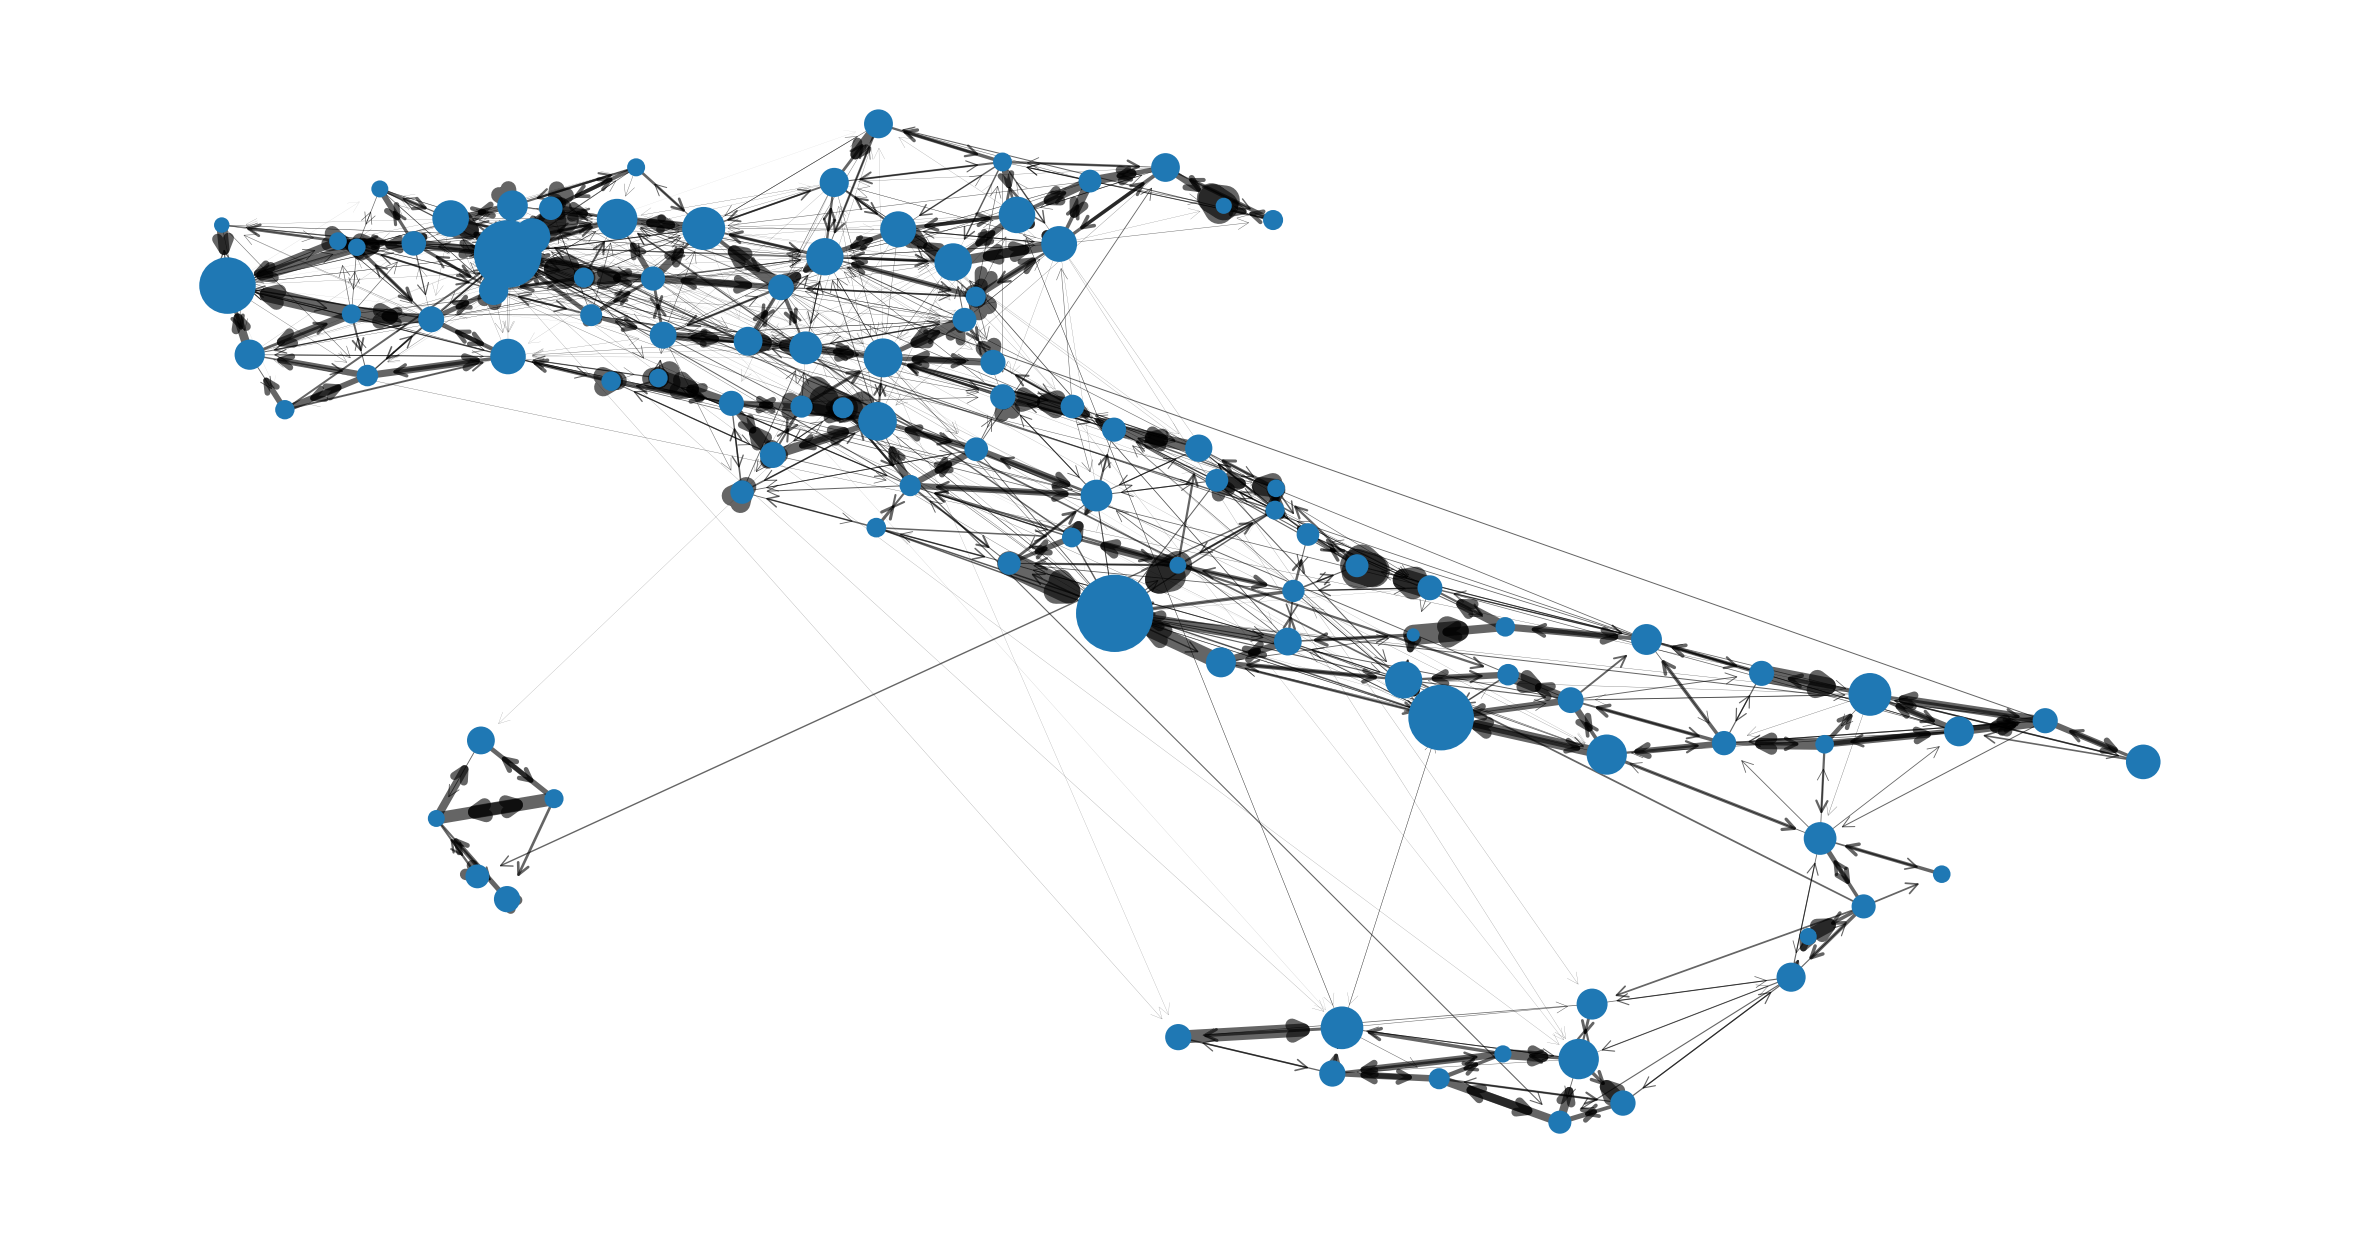

In [13]:
# Showcase connectivity
print("CONNECTIVITY:\n•",mobility_graph.number_of_nodes(),"nodes;\n•",mobility_graph.number_of_edges(),"edges.")

# Create nodal population list
population_list = [10000*mobility_graph.population[i] for i in list(mobility_graph.nodes)] / sum([mobility_graph.population[i] for i in list(mobility_graph.nodes)])

# Visualize Graph
plt.figure(figsize=(15,8))
nx.draw_networkx_nodes(mobility_graph, 
                       pos=mobility_graph.position,
                       node_size=population_list) #list(mobility_graph.population)
nx.draw_networkx_edges(mobility_graph,
                       pos=mobility_graph.position, 
                       arrowstyle='->',
                       alpha = 0.6, 
                       width = 50*np.array(list(nx.get_edge_attributes(mobility_graph,'weight').values())))
plt.axis('off')
plt.show()

To add mobility, we use the adjacency matrix of the lattice and add some random noise

In [34]:
# Adjacency matrix
mobility = nx.adj_matrix(mobility_graph).toarray() ###+ np.identity(mobility_graph.number_of_nodes())

# Mobility matrix is adjacency matrix with some noise
###mobility = (np.random.rand(mobility_graph.number_of_nodes(), mobility_graph.number_of_nodes())) * mobility_matrix

# Choose random subpopulation sizes
subpopulation_sizes = np.array(list(mobility_graph.population.values())) ###np.random.randint(50,100,M)

In [71]:
# outbreak source is the first compartment
outbreak_source='random'

# Initialize the model
model = SIRModel(
            mobility,
            subpopulation_sizes,
            outbreak_source=outbreak_source,
            dt=0.1,                      # simulation time interval
            dt_save=1,                 # time interval when to save observables
            I0=100,                    # number of initial infected
            VERBOSE=True,              # print verbose output
            T_max=200
        )

In [72]:
result = model.run_simulation()

Starting Simulation ...
Simulation completed
Time: 0min 17.25s


## Results

### Epidemic curve

In [81]:
model.population.shape[0]

107

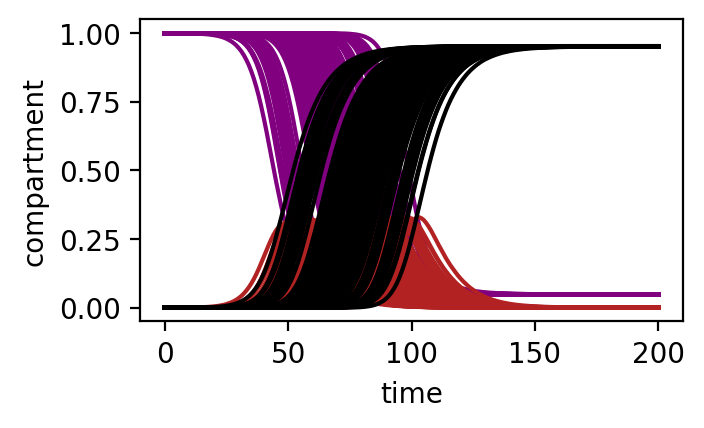

In [90]:
matplotlib.rc('figure', dpi=200)

figure = plt.figure(figsize=(3.5,2))

plt.plot(result['t'], result['S'], label='S', color='purple')
plt.plot(result['t'], result['I'], label='I', color='firebrick')
plt.plot(result['t'], result['R'], label='R', color='k')
#plt.legend(frameon=False, loc='center right')
plt.xlabel("time")
plt.ylabel("compartment")
plt.show()

In [93]:
plt.figsize=(20, 25)
for province in range(model.population.shape[0]):
        plt.subplot(57, 50, province+1)
        #plt.semilogy()            # set semi-log scale for y axis
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.xlabel("Time", fontsize=15)
        plt.ylabel("Fraction", fontsize=15)
        plt.title(f'Province {province+1}', fontsize=17)
        plt.plot(result['t'], result['S'][:], label='S', color='purple')
        plt.plot(result['t'], result['I'], label='I', color='firebrick')
        plt.plot(result['t'], result['R'], label='R', color='k')

plt.tight_layout()

Error in callback <function flush_figures at 0x1267d4550> (for post_execute):


KeyboardInterrupt: 

In [67]:
model.observables['S'][0]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [66]:
model.observables['S'][10]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999878,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99996241, 1.        , 0.99999678, 1.        , 1.        ,
       0.99997182, 1.        , 0.99980238, 0.99922417, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [65]:
model.observables['S'][20]

array([1.        , 1.        , 0.99997826, 0.99999659, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99998933,
       1.        , 0.99999606, 1.        , 1.        , 0.99999757,
       0.99950008, 0.9999392 , 0.99998495, 0.99996405, 0.99983677,
       0.9994317 , 0.9999585 , 0.99600386, 0.98898036, 1.        ,
       1.        , 1.        , 1.        , 0.99999705, 0.9999913 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999004,
       1.        , 1.        , 0.99997952, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999758, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [64]:
model.observables['S'][40]

array([0.99993651, 0.99926598, 0.99809805, 0.9996471 , 0.99980302,
       0.99988306, 0.99996813, 0.99997663, 0.99998176, 0.99989711,
       0.99998631, 0.99934904, 0.99957107, 0.99977341, 0.99883321,
       0.99934342, 0.99721787, 0.99953158, 0.99928561, 0.99848442,
       0.91630582, 0.97897343, 0.9933014 , 0.9860082 , 0.94821065,
       0.91522331, 0.97627668, 0.61885615, 0.46584917, 0.99978067,
       0.99980834, 0.99947907, 0.99945284, 0.99921006, 0.99742489,
       0.99971512, 0.99902997, 0.9998796 , 0.99989143, 0.99996796,
       0.99949604, 0.99998453, 0.99981733, 0.99924589, 0.99695409,
       0.99968517, 0.99952641, 0.99160237, 0.99992753, 0.99883736,
       0.9998577 , 0.9998798 , 0.99991231, 0.99978361, 0.99998807,
       1.        , 0.99999611, 0.99992752, 0.99999908, 1.        ,
       0.99998699, 0.99998745, 0.99998695, 0.99985367, 0.99990589,
       1.        , 0.99999476, 1.        , 1.        , 0.99999169,
       0.99999714, 0.99996618, 1.        , 0.99991363, 0.99972